<a href="https://colab.research.google.com/github/umbutun/hands-on-machine-learning-practice/blob/main/notebooks/chapter_06_ensemble_learning/chapter_06_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chapter 6 – Ensemble Learning and Random Forests**

_This notebook contains all the sample code and solutions to the exercises in chapter 6._

# Setup

This project requires Python 3.10 or above:

In [1]:
import sys

assert sys.version_info >= (3, 10)

It also requires Scikit-Learn ≥ 1.6.1:

In [2]:
from packaging.version import Version
import sklearn

assert Version(sklearn.__version__) >= Version("1.6.1")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's  define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [4]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')


IMAGES_PATH = Path("/content/drive/My Drive/Colab Notebooks/hands-on-ml/ch6-images")
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Mounted at /content/drive


# Voting Classifiers

This code cell, which generates Figure 6-3, simulates a series of coin tosses with a slight bias and visualizes the 'Law of Large Numbers'. Here's a breakdown:

*   **`heads_proba = 0.51`**: Sets the probability of getting heads in a single coin toss to 51% (a slightly biased coin).
*   **`rng = np.random.default_rng(seed=42)`**: Initializes a random number generator for reproducibility.
*   **`coin_tosses = (rng.random((10000, 10)) < heads_proba).astype(np.int32)`**: This line simulates 10,000 sets of 10 coin tosses. For each of the 10,000 instances, it generates 10 random numbers between 0 and 1. If a number is less than `heads_proba` (0.51), it's considered a 'head' (1); otherwise, it's a 'tail' (0). The result is a 2D array of 0s and 1s.
*   **`cumulative_heads = coin_tosses.cumsum(axis=0)`**: Calculates the cumulative sum of heads along the first axis (rows). This means for each of the 10 series of tosses, it keeps track of the total number of heads up to that point.
*   **`cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)`**: Divides the cumulative number of heads by the corresponding number of tosses (from 1 to 10,000) to get the ratio of heads at each step. This effectively shows how the proportion of heads changes over time for each series of coin tosses.
*   **`plt.figure(figsize=(8, 3.5))`**: Creates a new figure for the plot with a specified size.
*   **`plt.plot(cumulative_heads_ratio)`**: Plots the calculated cumulative heads ratios. Each line on the graph represents one of the 10 series of coin tosses.
*   **`plt.plot([0, 10000], [0.51, 0.51], "k--", ...)`**: Adds a dashed black line at `y=0.51` to indicate the true probability of heads.
*   **`plt.plot([0, 10000], [0.5, 0.5], "k-", ...)`**: Adds a solid black line at `y=0.5` for comparison.
*   **`plt.xlabel("Number of coin tosses")`, `plt.ylabel("Heads ratio")`, `plt.legend(...)`, `plt.axis(...)`, `plt.grid()`**: These lines set the labels, legend, axis limits, and add a grid to the plot for better readability.

In essence, this cell beautifully demonstrates the 'Law of Large Numbers', showing that as the number of coin tosses increases, the observed ratio of heads for each series converges towards the true probability of heads (0.51 in this case).

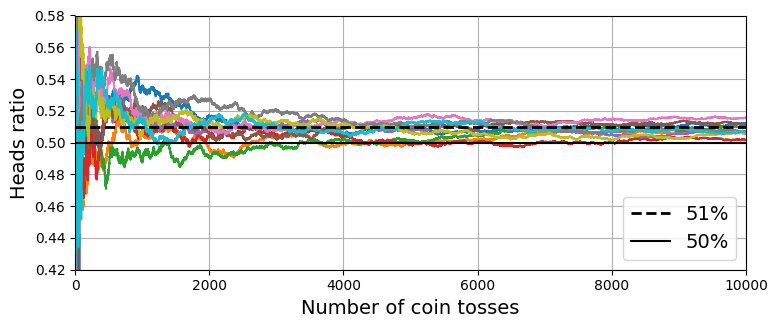

In [5]:
# extra code – this cell generates Figure 6–3

import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
rng = np.random.default_rng(seed=42)
coin_tosses = (rng.random((10000, 10)) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
save_fig("law_of_large_numbers")
plt.show()

This code cell sets up a Voting Classifier for a classification task:

*   **Imports**: It imports necessary modules from `sklearn` for creating datasets (`make_moons`), ensemble methods (`RandomForestClassifier`, `VotingClassifier`), linear models (`LogisticRegression`), model selection (`train_test_split`), and support vector machines (`SVC`).
*   **Dataset Creation**: `X, y = make_moons(n_samples=500, noise=0.30, random_state=42)` generates a synthetic 2D binary classification dataset, often used for demonstrating classification algorithms.
*   **Data Splitting**: `X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)` divides the generated dataset into training and testing subsets.
*   **Voting Classifier Initialization**: A `VotingClassifier` named `voting_clf` is created. This ensemble combines the predictions of multiple diverse base classifiers:
    *   `LogisticRegression(random_state=42)`
    *   `RandomForestClassifier(random_state=42)`
    *   `SVC(random_state=42)`
*   **Model Training**: `voting_clf.fit(X_train, y_train)` trains the `VotingClassifier` on the training data. During this step, each of the base estimators (`lr`, `rf`, `svc`) is individually trained on `X_train` and `y_train`.

In [6]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

When you fit a `VotingClassifier`, it clones every estimator and fits the clones. The original estimators are available via the `estimators` attribute, while the fitted clones are available via the `estimators_` attribute. If you prefer a dict rather than a list, you can use `named_estimators` or `named_estimators_` instead.

In [7]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


When you call the voting classifier’s `predict()` method, it performs hard voting. For example, the voting classifier predicts class 1 for the first instance of the test set, because two out of three classifiers predict that class:

In [8]:
voting_clf.predict(X_test[:1])

array([1])

In [9]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]

[array([1]), array([1]), array([0])]

In [10]:
voting_clf.score(X_test, y_test)

0.912

If all classifiers are able to estimate class probabilities (i.e., if they all have a `predict_proba()` method), then you should generally tell `Scikit-Learn` to predict the class with the highest class probability, averaged over all the individual classifiers.This is not the case for the `SVC` class by default, so you need to set its `probability` hyperparameter to `True`

In [11]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

# Bagging and Pasting
## Bagging and Pasting in Scikit-Learn

Another way is to use the same training algorithm for every predictor but train them on different random subsets of the training set. When sampling is performed with replacement,⁠ this method is called `bagging`⁠ (short for `bootstrap aggregating`⁠). When sampling is performed without replacement, it is called `pasting`.⁠


The following code trains an ensemble of 500 `decision tree classifiers`: `max_samples` can alternatively be set to a float between 0.0 and 1.0, in which case the max number of sampled instances is equal to the size of the training set times `max_samples`. Each tree is trained on 100 training instances randomly sampled from the training set with replacement. The `n_jobs` parameter tells `Scikit-Learn` the number of CPU cores to use for training and predictions, and –1 tells `Scikit-Learn` to use all available cores:

In [12]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

This code cell, which generates Figure 6-5, compares the decision boundaries of a single `DecisionTreeClassifier` and a `BaggingClassifier` (an ensemble of Decision Trees). Here's a breakdown:

*   **`plot_decision_boundary(clf, X, y, alpha=1.0)` function**: This function takes a classifier (`clf`), data (`X`, `y`), and an `alpha` value for transparency. It creates a grid of points, makes predictions using the given classifier, and then plots the decision regions as filled contours (`plt.contourf`) and the decision boundary lines (`plt.contour`). It also plots the training instances (`X`, `y`) on top. The `axes` variable defines the plot's boundaries, and `x1`, `x2` are used to create the meshgrid for the decision surface.
*   **`tree_clf = DecisionTreeClassifier(random_state=42)`**: Initializes a single `DecisionTreeClassifier` with `random_state=42` for reproducibility.
*   **`tree_clf.fit(X_train, y_train)`**: Trains the single `DecisionTreeClassifier` on the training data.
*   **`fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)`**: Creates a figure with two subplots side-by-side to display the comparison.
*   **`plt.sca(axes[0])` and `plot_decision_boundary(tree_clf, X_train, y_train)`**: Selects the first subplot and calls `plot_decision_boundary` to draw the decision boundary for the single `DecisionTreeClassifier`.
*   **`plt.sca(axes[1])` and `plot_decision_boundary(bag_clf, X_train, y_train)`**: Selects the second subplot and calls `plot_decision_boundary` to draw the decision boundary for the `bag_clf` (which was defined in a previous cell as a `BaggingClassifier`).
*   **`plt.ylabel("")`**: Removes the y-axis label from the second subplot for cleaner presentation.

The figure visually demonstrates how bagging helps to smooth out the decision boundary, reducing overfitting compared to a single, unregularized decision tree.

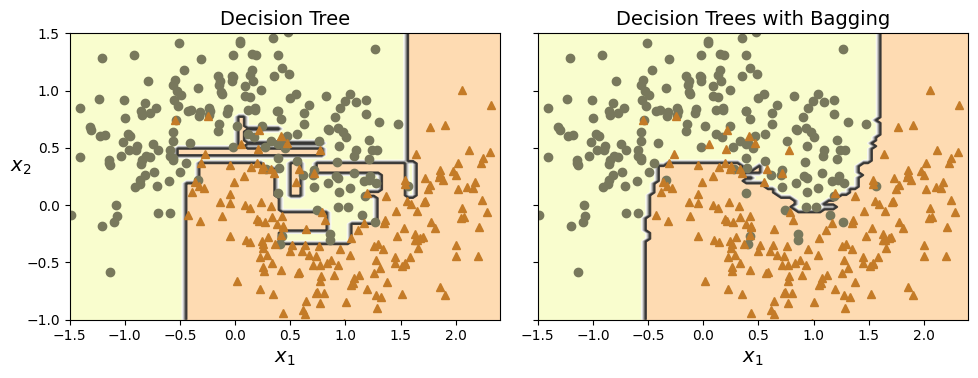

In [13]:
# extra code – this cell generates Figure 6–5

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
save_fig("decision_tree_vs_bagging_ensemble_of_500_trees")
plt.show()

## Out-of-Bag evaluation

In Scikit-Learn, you can set `oob_score=True` when creating a `BaggingClassifier` to request an automatic OOB evaluation after training. The following code demonstrates this. The resulting evaluation score is available in the `oob_score_` attribute:

In [14]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

The OOB decision function for each training instance is also available through the `oob_decision_function_` attribute. Since the base estimator has a `predict_proba()` method, the decision function returns the class probabilities for each training instance.

In [15]:
bag_clf.oob_decision_function_[:3]  # probas for the first 3 instances

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

In [16]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

If you randomly draw one instance from a dataset of size _m_, each instance in the dataset obviously has probability 1/_m_ of getting picked, and therefore it has a probability 1 – 1/_m_ of _not_ getting picked. If you draw _m_ instances with replacement, **all draws are independent** and therefore each instance has a probability (1 – 1/_m_)<sup>_m_</sup> of _not_ getting picked. Now let's use the fact that exp(_x_) is equal to the limit of (1 + _x_/_m_)<sup>_m_</sup> as _m_ approaches infinity. So if _m_ is large, the ratio of out-of-bag instances will be about exp(–1) ≈ 0.37. So roughly 63% (1 – 0.37) will be sampled.

In [17]:
# extra code – shows how to compute the 63% proba
print(1 - (1 - 1 / 1000) ** 1000)
print(1 - np.exp(-1))

0.6323045752290363
0.6321205588285577


# Random Forests

The following code trains a random forest classifier with 500 trees, each limited to maximum 16 leaf nodes, using all available CPU cores:

In [18]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

A Random Forest is equivalent to a bag of decision trees:

In [19]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

In [20]:
# extra code – verifies that the predictions are identical
bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
np.all(y_pred_bag == y_pred_rf)  # same predictions

np.True_

## Feature Importance

Another great quality of random forests is that they make it easy to measure the relative importance of each feature. `Scikit-Learn` computes this score automatically for each feature after training, then it scales the results so that the sum of all importances is equal to 1. You can access the result using the `feature_importances_` variable.

In [21]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


This code cell, which generates Figure 6-6, demonstrates how to visualize feature importances from a `RandomForestClassifier` on the MNIST dataset. Here's a breakdown:

*   **`from sklearn.datasets import fetch_openml`**: Imports the `fetch_openml` function to load datasets from OpenML.
*   **`X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False, parser='auto')`**: Loads the MNIST dataset, which consists of 70,000 images of handwritten digits (28x28 pixels each). `X_mnist` will contain the pixel data, and `y_mnist` will contain the corresponding labels.
*   **`rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)`**: Initializes a `RandomForestClassifier` with 100 decision trees for reproducibility.
*   **`rnd_clf.fit(X_mnist, y_mnist)`**: Trains the `RandomForestClassifier` on the entire MNIST dataset.
*   **`heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)`**: After training, `rnd_clf.feature_importances_` contains a score for each feature (pixel) indicating its importance in the classification task. This line reshapes the 1D array of 784 importance scores into a 28x28 2D array, representing the pixel grid of an image.
*   **`plt.imshow(heatmap_image, cmap="hot")`**: Displays this 28x28 array as an image using a 'hot' colormap, where brighter colors indicate higher feature importance.
*   **`cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])`**: Adds a colorbar to the plot to indicate the range of feature importance values.
*   **`cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)`**: Sets custom labels for the minimum and maximum ticks on the colorbar, making it easier to interpret.

This visualization effectively shows which pixels (features) are most important for the Random Forest Classifier to correctly identify handwritten digits, typically highlighting the central pixels that form the core of the digits.

In [22]:
# extra code – this cell generates Figure 6–6

from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
save_fig("MNIST_pixel_importance")
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/datasets/_openml.py:75: RuntimeWarning: Invalid cache, redownloading file
  warn("Invalid cache, redownloading file", RuntimeWarning)


ValueError: md5 checksum of local file for data/v1/download/52667 does not match description: expected: 0298d579eb1b86163de7723944c7e495 but got 4faec5c39a1f821270a5878880fbfc8c. Downloaded file could have been modified / corrupted, clean cache and retry...

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


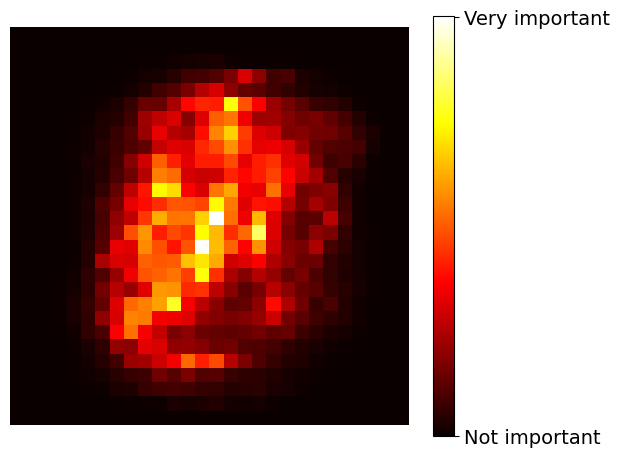

In [23]:
# extra code – this cell generates Figure 6–6 using Keras datasets

import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST dataset using Keras datasets
# This bypasses the fetch_openml function that was causing SSL errors.
(X_mnist_train_full, y_mnist_train_full), (X_mnist_test, y_mnist_test) = tf.keras.datasets.mnist.load_data()

# Combine train and test for the purpose of the example if needed by subsequent cells
# For feature importance, we usually fit on the training portion
X_mnist = np.concatenate([X_mnist_train_full, X_mnist_test], axis=0)
y_mnist = np.concatenate([y_mnist_train_full, y_mnist_test], axis=0)

# Reshape X_mnist to a 2D array (flatten images)
X_mnist = X_mnist.reshape(X_mnist.shape[0], -1)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
save_fig("MNIST_pixel_importance")
plt.show()

# Boosting
## AdaBoost

This code cell, which generates Figure 6-8, simulates an iterative boosting process similar to AdaBoost using `Support Vector Classifiers (SVCs)` as base estimators. It visually demonstrates how a series of weak learners (SVCs) are combined and weighted to improve classification accuracy, particularly highlighting the effect of different `learning_rate` values.

Here's a breakdown of its key actions:

*   **Initialization**: It sets up the plotting environment with two subplots to compare the boosting process with different learning rates.
*   **Iterative Training Loop**: The code iterates to train five `SVC` models in sequence for each `learning_rate`.
*   **Sample Weighting**: Before training each `SVC`, instances are assigned `sample_weights`. Initially, all weights are equal. After each `SVC` is trained, the weights of misclassified instances are increased, forcing subsequent `SVCs` to pay more attention to these difficult-to-classify points.
*   **Error and Alpha Calculation**: For each `SVC`, the weighted error rate (`r`) is calculated. This `r` is then used, along with the `learning_rate`, to determine `alpha`, a weighting factor for the current `SVC`'s contribution to the ensemble.
*   **Weight Normalization**: After updating, the `sample_weights` are normalized.
*   **Decision Boundary Plotting**: For each trained `SVC`, its decision boundary is plotted, showing how the model's focus shifts over iterations.
*   **Annotations**: The first subplot includes numerical labels (1 through 5) to indicate the progression of decision boundaries through the five iterations.

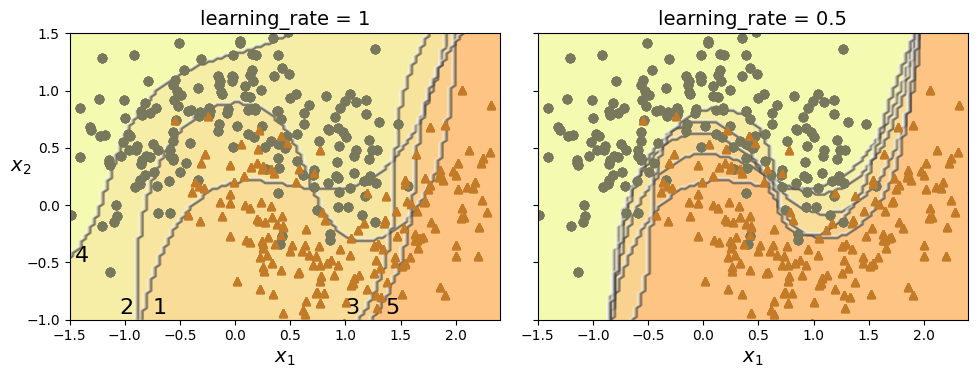

In [24]:
# extra code – this cell generates Figure 6–8

m = len(X_train)  # number of instances

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")
save_fig("boosting_plot")
plt.show()

This code cell initializes and trains an `AdaBoostClassifier` using `DecisionTreeClassifier` as its base estimator. Here's a breakdown of its key actions:

*   **`ada_clf = AdaBoostClassifier(...)`**: Instantiates an `AdaBoostClassifier` with the following parameters:
    *   **`DecisionTreeClassifier(max_depth=1)`**: Specifies that the base learners (weak learners) will be Decision Trees, each limited to a maximum depth of 1. These are often referred to as `'decision stumps'`.
    *   **`n_estimators=30`**: Sets the number of boosting stages (i.e., the number of decision stumps to train) to 30.
    *   **`learning_rate=0.5`**: Controls the contribution of each weak learner to the final ensemble. A lower learning rate requires more estimators but can lead to better generalization.
    *   **`random_state=42`**: Ensures reproducibility of the results.
    *   **`algorithm="SAMME"`**: Specifies the boosting algorithm. 'SAMME' (Stagewise Additive Modeling using a Multiclass Exponential loss function) is used for multi-class classification problems, while 'SAMME.R' (SAMME with Real boosting) can use class probabilities to update weights and often performs better.
*   **`ada_clf.fit(X_train, y_train)`**: Trains the `AdaBoostClassifier` on the training data `X_train` and `y_train`. During this process, the classifier iteratively fits decision stumps, adjusting the weights of misclassified training instances at each step, making subsequent stumps focus more on those instances.

In [25]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=30,
    learning_rate=0.5, random_state=42, algorithm="SAMME")
ada_clf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoostClassifier(algorithm='SAMME',
                   estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=30, random_state=42)

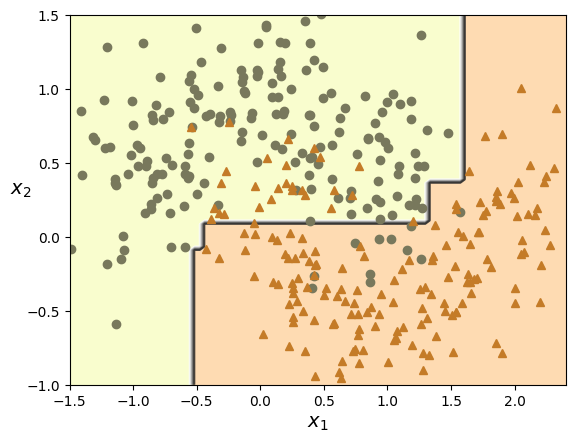

In [26]:
# extra code – in case you're curious to see what the decision boundary
#              looks like for the AdaBoost classifier
plot_decision_boundary(ada_clf, X_train, y_train)

## Gradient Boosting

This code cell sets up a simple quadratic dataset and then trains an initial `DecisionTreeRegressor` on it. Here's a breakdown:

*   **`m = 100`**: Sets the number of data instances to 100.
*   **`rng = np.random.default_rng(seed=42)`**: Initializes a random number generator for reproducibility.
*   **`X = rng.random((m, 1)) - 0.5`**: Generates 100 random numbers between -0.5 and 0.5, forming the input feature `X`.
*   **`noise = 0.05 * rng.standard_normal(m)`**: Generates Gaussian noise with a standard deviation of 0.05.
*   **`y = 3 * X[:, 0] ** 2 + noise`**: Creates the target variable `y` using a quadratic relationship `(3x^2)` with added Gaussian noise, simulating a dataset for regression.
*   **`tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)`**: Initializes a `DecisionTreeRegressor` model. `max_depth=2` limits the complexity of the tree to prevent overfitting, and `random_state=42` ensures reproducibility.
*   **`tree_reg1.fit(X, y)`**: Trains the `DecisionTreeRegressor` on the generated input features `X` and target values `y`.

In [27]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

m = 100  # number of instances
rng = np.random.default_rng(seed=42)
X = rng.random((m, 1)) - 0.5
noise = 0.05 * rng.standard_normal(m)
y = 3 * X[:, 0] ** 2 + noise  # y = 3x² + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

This code cell continues the Gradient Boosting process by training a second `DecisionTreeRegressor` (`tree_reg2`) on the *residuals* of the first tree (`tree_reg1`).

Here's a breakdown of its key actions:

*   **`y2 = y - tree_reg1.predict(X)`**: This is a crucial step in Gradient Boosting. Instead of training the next model on the original target `y`, it's trained on the *residual errors* (`y2`) that the first tree (`tree_reg1`) made in its predictions. This means `tree_reg2` learns to correct the mistakes of `tree_reg1`.
*   **`tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)`**: A new `DecisionTreeRegressor` is initialized with the same `max_depth` (2). Importantly, a *different `random_state` (43)* is used here. This is a common practice in ensemble methods, especially those involving randomization. Using a different `random_state` ensures that `tree_reg2` will be a different model, likely having different internal splits and decision rules compared to `tree_reg1`. This diversity among the individual models is key to the effectiveness of ensemble learning, as each model brings a unique perspective to learning the overall pattern or correcting errors.
*   **`tree_reg2.fit(X, y2)`**: `tree_reg2` is then trained on the original features `X` but with the new target `y2` (the residuals from `tree_reg1`). This allows `tree_reg2` to specifically target and reduce the errors that `tree_reg1` left behind.

In [28]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=43)

Now let's train another decision tree regressor on the residual errors made by the previous predictor:

In [29]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=44)

This code cell demonstrates how the ensemble of three `DecisionTreeRegressor` models, trained sequentially in the Gradient Boosting fashion, makes a final prediction. Here's a breakdown:

*   **`X_new = np.array([[-0.4], [0.], [0.5]])`**: Defines new input instances for which the ensemble needs to make predictions. These are a small array of 2D points.
*   **`sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))`**: This is the core of the ensemble's prediction. It iterates through each of the three trained decision tree regressors (`tree_reg1`, `tree_reg2`, and `tree_reg3`). For each tree, it calls its `predict()` method on `X_new` to get its individual prediction. Finally, it sums up the predictions from all three trees. In Gradient Boosting, the final prediction is the sum of the predictions from all the individual base learners, each contributing to reduce the residual errors from the previous learners.

In [32]:
X_new = np.array([[-0.4], [0.], [0.5]])
print(f"{tree_reg1.predict(X_new)=}\n"
      f"{tree_reg2.predict(X_new)=}\n"
      f"{tree_reg3.predict(X_new)=}"
      )
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

tree_reg1.predict(X_new)=array([0.57461198, 0.0910793 , 0.44383327])
tree_reg2.predict(X_new)=array([-0.01340088, -0.01340088,  0.27169237])
tree_reg3.predict(X_new)=array([ 0.01235424, -0.03716422, -0.04638315])


array([0.57356534, 0.0405142 , 0.66914249])

This code cell, which generates Figure 6-9, visually demonstrates the iterative nature of Gradient Boosting for regression. Here's a breakdown of its key actions:

*   **`plot_predictions` function**: This helper function takes a list of `regressors`, input data (`X`, `y`), plot `axes`, plotting `style`, and `labels`. It generates a smooth prediction curve by summing the predictions of all provided regressors over a dense range of `x1` values. It then plots both the original training data and the ensemble's prediction curve, adding a legend and setting axis limits.
*   **Figure Setup**: `plt.figure(figsize=(11, 11))` creates a large figure to accommodate multiple subplots. The subsequent `plt.subplot()` calls divide the figure into a 3x2 grid to show the progression of the boosting process.
*   **Subplot 1 (`plt.subplot(3, 2, 1)`)**:
plt.subplot(3, 2, 1):

    * The first number, 3, indicates that you want a grid of 3 rows for your plots.
    * The second number, 2, indicates that you want a grid of 2 columns for your plots.
    * The third number, 1, indicates that the current subplot being created (or selected) is the 1st plot in this 3x2 grid, counting from left to right, then top to bottom.

    Plots the predictions of the *first* decision tree (`tree_reg1`) against the original `X` and `y`. The title "Residuals and tree predictions" suggests this is the initial fit.
*   **Subplot 2 (`plt.subplot(3, 2, 2)`)**: Shows the ensemble prediction after just one tree, which is simply `h_1(x_1)`.
*   **Subplot 3 (`plt.subplot(3, 2, 3)`)**: Plots the predictions of the *second* decision tree (`tree_reg2`) against the *first set of residuals* (`y2`), labeled as `y - h_1(x_1)`. This highlights that `tree_reg2` is learning from the errors of `tree_reg1`.
*   **Subplot 4 (`plt.subplot(3, 2, 4)`)**: Displays the ensemble prediction formed by summing `tree_reg1` and `tree_reg2` (`h_1(x_1) + h_2(x_1)`). You can see the prediction improving.
*   **Subplot 5 (`plt.subplot(3, 2, 5)`)**: Plots the predictions of the *third* decision tree (`tree_reg3`) against the *second set of residuals* (`y3`), labeled `y - h_1(x_1) - h_2(x_1)`. This shows `tree_reg3` learning from the remaining errors.
*   **Subplot 6 (`plt.subplot(3, 2, 6)`)**: Shows the final ensemble prediction by summing all three trees (`h_1(x_1) + h_2(x_1) + h_3(x_1)`).

This series of plots effectively illustrates the core idea of Gradient Boosting: each new predictor attempts to correct the errors (residuals) made by the previous ensemble, leading to progressively better overall predictions.

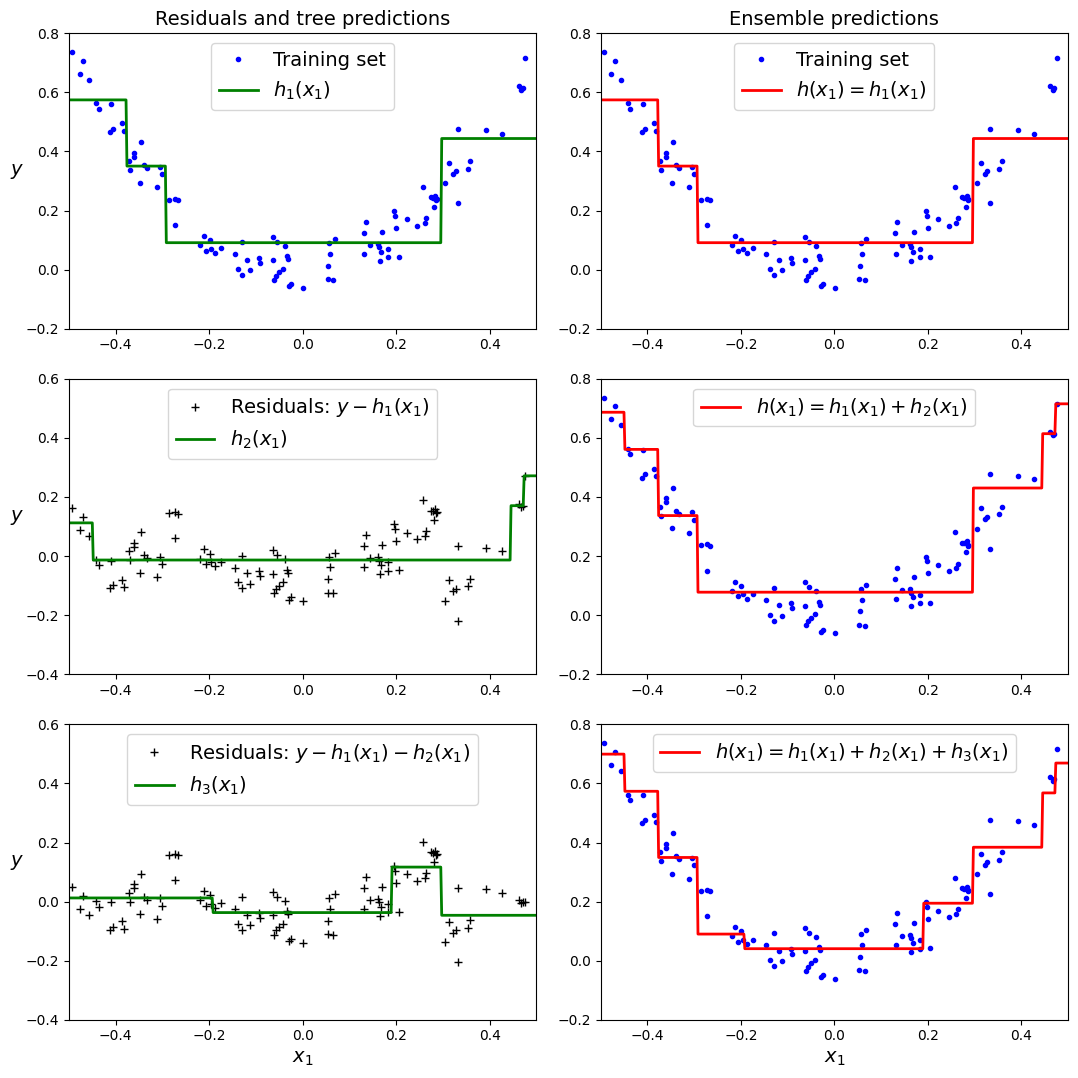

In [33]:
# extra code – this cell generates Figure 6–9

def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")
save_fig("gradient_boosting_plot")
plt.show()

This code cell initializes and trains a `GradientBoostingRegressor` (GBRT) from `Scikit-Learn`. Here's a breakdown of its key actions:

*   **`gbrt = GradientBoostingRegressor(...)`**: Instantiates a `GradientBoostingRegressor` with the following hyperparameters:
    *   **`max_depth=2`**: Limits the maximum depth of each individual regression tree to 2. This helps to prevent overfitting and makes the weak learners simpler.
    *   **`n_estimators=3`**: Sets the number of boosting stages (i.e., the number of individual regression trees) to 3 for comparison with previous manual steps. This is a small number for illustrative purposes, as boosting often requires many estimators.
    *   **`learning_rate=1.0`**: Controls the contribution of each tree to the overall ensemble's prediction. A learning rate of 1.0 means each tree's prediction is added fully to the ensemble. Smaller learning rates are common to prevent overfitting, but might require more estimators.
    *   **`random_state=42`**: Ensures reproducibility of the results.
*   **`gbrt.fit(X, y)`**: Trains the `GradientBoostingRegressor` on the input features `X` and target values `y`. During training, the model sequentially builds trees, each attempting to correct the errors (residuals) of the preceding trees in the ensemble.

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3,
                                 learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

This code cell initializes and trains another `GradientBoostingRegressor` (`gbrt_best`) with different hyperparameters, aimed at potentially achieving better performance, particularly by using a lower learning rate and early stopping.

Here's a breakdown of its key actions:

*   **`gbrt_best = GradientBoostingRegressor(...)`**: Instantiates a `GradientBoostingRegressor` with the following hyperparameters:
    *   **`max_depth=2`**: Limits the maximum depth of each individual regression tree to 2, consistent with previous examples, helping to prevent overfitting.
    *   **`learning_rate=0.05`**: Sets a much lower learning rate compared to the previous `gbrt` model (which used 1.0). A lower learning rate typically requires more estimators but can lead to a more robust model and better generalization by taking smaller steps in the gradient descent direction.
    *   **`n_estimators=500`**: Specifies a larger number of boosting stages (500 trees) to compensate for the lower `learning_rate`. This allows the model to learn more gradually.
    *   **`n_iter_no_change=10`**: This is an early stopping parameter. It instructs the model to stop training if the validation score does not improve for `10` consecutive iterations. This prevents overfitting and finds an optimal number of estimators without manually tuning `n_estimators`.
    *   **`random_state=42`**: Ensures reproducibility of the results.
*   **`gbrt_best.fit(X, y)`**: Trains this configured `GradientBoostingRegressor` on the input features `X` and target values `y`. Due to `n_iter_no_change`, the actual number of estimators used might be less than 500 if early stopping is triggered.

In [35]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500,
    n_iter_no_change=10, random_state=42)
gbrt_best.fit(X, y)

GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=500,
                          n_iter_no_change=10, random_state=42)

In [36]:
gbrt_best.n_estimators_

53

This code cell, which generates Figure 6-10, visually compares the prediction curves of two `GradientBoostingRegressor` models trained with different hyperparameters (`gbrt` and `gbrt_best`). Here's a breakdown of its key actions:

*   **Figure Setup**: `fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)` creates a figure with two subplots side-by-side, sharing the same y-axis for easy comparison.
*   **First Subplot (`plt.sca(axes[0])`)**:
It uses the `plot_predictions` function (defined earlier) to plot the predictions of the `gbrt` model (which had `learning_rate=1.0` and `n_estimators=3`).
*   **Second Subplot (`plt.sca(axes[1])`)**: It plots the predictions of the `gbrt_best` model (which had `learning_rate=0.05` and a larger, optimized `n_estimators`).

The figure visually demonstrates how different hyperparameter choices, particularly a lower `learning_rate` and an optimized number of `n_estimators`, can lead to a smoother and potentially more accurate prediction curve in Gradient Boosting.

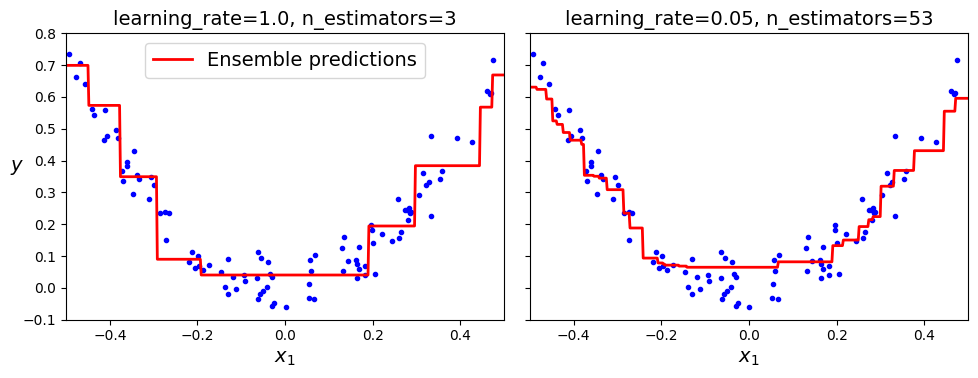

In [37]:
# extra code – this cell generates Figure 6–10

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")
save_fig("gbrt_ensemble_predictions")
plt.show()

Import housing data (chapter 2) to train GBRT

In [41]:
from pathlib import Path
import tarfile
import urllib.request

import pandas as pd
from sklearn.model_selection import train_test_split

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets", filter='data')
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)

This code cell initializes and trains a `HistGradientBoostingRegressor` (a fast Gradient Boosting implementation) within a Scikit-Learn pipeline. Here's a breakdown of its key actions:

*   **`hgb_reg = make_pipeline(...)`**: Creates a pipeline named `hgb_reg` with two main steps:
    1.  **`make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]), remainder="passthrough", force_int_remainder_cols=False)`**: This transformer preprocesses the input features:
        *   It applies `OrdinalEncoder` to the `"ocean_proximity"` column, converting its categorical text values into numerical ordinal values.
        *   `remainder="passthrough"` ensures that all other columns (numerical features) are passed through without any transformation.
        *   `force_int_remainder_cols=False` prevents numerical columns from being coerced into integer types if they contain floats.
    2.  **`HistGradientBoostingRegressor(categorical_features=[0], random_state=42)`**: This is the actual regression model.
        *   `categorical_features=[0]` tells the `HistGradientBoostingRegressor` that the first feature (which is `ocean_proximity` after encoding) should be treated as a categorical feature, allowing the algorithm to handle it appropriately for better performance.
        *   `random_state=42` ensures reproducibility.
*   **`hgb_reg.fit(housing, housing_labels)`**: Trains the entire pipeline. The `OrdinalEncoder` first transforms `housing`, and then the `HistGradientBoostingRegressor` is trained on the transformed data and `housing_labels`.

In [39]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OrdinalEncoder

hgb_reg = make_pipeline(
    make_column_transformer((OrdinalEncoder(), ["ocean_proximity"]),
                            remainder="passthrough",
                            force_int_remainder_cols=False),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=42)
)
hgb_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('ordinalencoder',
                                                  OrdinalEncoder(),
                                                  ['ocean_proximity'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(categorical_features=[0],
                                               random_state=42))])

This code cell evaluates the `hgb_reg` (HistGradientBoostingRegressor pipeline) model using cross-validation and then presents descriptive statistics of the Root Mean Squared Error (RMSE) obtained from these evaluations. Here's a breakdown of its key actions:

*   **`hgb_rmses = -cross_val_score(...)`**: This line performs the k-fold cross-validation:
    *   It takes the `hgb_reg` pipeline, the `housing` features, and `housing_labels` as input.
    *   `scoring="neg_root_mean_squared_error"`: Specifies that the evaluation metric should be the negative Root Mean Squared Error. Scikit-Learn's `cross_val_score` expects metrics where 'higher is better', so for error metrics (where 'lower is better'), it's common to use their negative versions. The `-` sign before `cross_val_score` then converts these negative RMSEs back to positive RMSE values.
    *   `cv=10`: Indicates that 10-fold cross-validation should be performed. This means the dataset will be split into 10 folds, and the model will be trained and evaluated 10 times, each time using a different fold as the test set and the remaining 9 as the training set.
*   **`pd.Series(hgb_rmses).describe()`**: After obtaining the 10 RMSE scores from the cross-validation, they are converted into a pandas Series, and the `.describe()` method is called. This provides a summary of the RMSE distribution, including:
    *   `count`: The number of RMSE scores (which is `cv=10`).
    *   `mean`: The average RMSE across all folds.
    *   `std`: The standard deviation of the RMSE scores, indicating their variability.
    *   `min`, `25%`, `50%` (median), `75%`, `max`: Various percentiles of the RMSE scores, giving a detailed view of the model's performance distribution across different folds.

This evaluation provides a robust estimate of the model's generalization performance and its stability across different subsets of the data.

In [42]:
# extra code – evaluate the RMSE stats for the hgb_reg model

from sklearn.model_selection import cross_val_score

hgb_rmses = -cross_val_score(hgb_reg, housing, housing_labels,
                             scoring="neg_root_mean_squared_error", cv=10)
pd.Series(hgb_rmses).describe()

,0
count,10.000000
mean,47613.307194
std,1295.422509
min,44963.213061
25%,47001.233485
50%,48000.963564
75%,48488.093243
max,49176.368465


# Stacking

This code cell initializes and trains a `StackingClassifier` from `Scikit-Learn`. Here's a breakdown of its key actions:

*   **`from sklearn.ensemble import StackingClassifier`**: Imports the `StackingClassifier` class, which allows combining multiple diverse models (base estimators) and training a final meta-model (final estimator) to make predictions based on the outputs of the base estimators.
*   **`stacking_clf = StackingClassifier(...)`**: Instantiates a `StackingClassifier` with the following parameters:
    *   **`estimators=[...]`**: This is a list of the base classifiers that will form the first layer of the stacking ensemble, it includes:
        *   `('lr', LogisticRegression(random_state=42))`: A Logistic Regression classifier.
        *   `('rf', RandomForestClassifier(random_state=42))`: A Random Forest Classifier.
        *   `('svc', SVC(probability=True, random_state=42))`: A Support Vector Classifier, with `probability=True` enabled to allow for soft voting or probability-based predictions, which can be useful for the final estimator.
    *   **`final_estimator=RandomForestClassifier(random_state=43)`**: This is the meta-model (or blender) that learns to combine the predictions of the base estimators. It's a `RandomForestClassifier` in this example. Using different random states (43) for different parts of an ensemble can subtly introduce more diversity.
    *   **`cv=5`**: Specifies that 5-fold cross-validation should be used during the training of the final estimator. For each fold, the base estimators are trained on a subset of the training data and then make predictions on the held-out fold. These predictions serve as the training data for the `final_estimator`.
*   **`stacking_clf.fit(X_train, y_train)`**: Trains the entire `StackingClassifier` on the training data (`X_train`, `y_train`). During this process, the base estimators are trained, their out-of-fold predictions are generated, and then the `final_estimator` is trained on these predictions.

In [43]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [44]:
stacking_clf.score(X_test, y_test)

0.928

# Exercise solutions

## 1. to 7.

1. If you have trained five different models and they all achieve 95% precision, you can try combining them into a voting ensemble, which will often give you even better results. It works better if the models are very different (e.g., an SVM classifier, a Decision Tree classifier, a Logistic Regression classifier, and so on). It is even better if they are trained on different training instances (that's the whole point of bagging and pasting ensembles), but if not this will still be effective as long as the models are very different.
2. A hard voting classifier just counts the votes of each classifier in the ensemble and picks the class that gets the most votes. A soft voting classifier computes the average estimated class probability for each class and picks the class with the highest probability. This gives high-confidence votes more weight and often performs better, but it works only if every classifier is able to estimate class probabilities (e.g., for the SVM classifiers in Scikit-Learn you must set `probability=True`).
3. It is quite possible to speed up training of a bagging ensemble by distributing it across multiple servers, since each predictor in the ensemble is independent of the others. The same goes for pasting ensembles and Random Forests, for the same reason. However, each predictor in a boosting ensemble is built based on the previous predictor, so training is necessarily sequential, and you will not gain anything by distributing training across multiple servers. Regarding stacking ensembles, all the predictors in a given layer are independent of each other, so they can be trained in parallel on multiple servers. However, the predictors in one layer can only be trained after the predictors in the previous layer have all been trained.
4. With out-of-bag evaluation, each predictor in a bagging ensemble is evaluated using instances that it was not trained on (they were held out). This makes it possible to have a fairly unbiased evaluation of the ensemble without the need for an additional validation set. Thus, you have more instances available for training, and your ensemble can perform slightly better.
5. When you are growing a tree in a Random Forest, only a random subset of the features is considered for splitting at each node. This is true as well for Extra-Trees, but they go one step further: rather than searching for the best possible thresholds, like regular Decision Trees do, they use random thresholds for each feature. This extra randomness acts like a form of regularization: if a Random Forest overfits the training data, Extra-Trees might perform better. Moreover, since Extra-Trees don't search for the best possible thresholds, they are much faster to train than Random Forests. However, they are neither faster nor slower than Random Forests when making predictions.
6. If your AdaBoost ensemble underfits the training data, you can try increasing the number of estimators or reducing the regularization hyperparameters of the base estimator. You may also try slightly increasing the learning rate.
7. If your Gradient Boosting ensemble overfits the training set, you should try decreasing the learning rate. You could also use early stopping to find the right number of predictors (you probably have too many).

## 8. Voting Classifier

Exercise: _Load the MNIST data and split it into a training set, a validation set, and a test set (e.g., use 50,000 instances for training, 10,000 for validation, and 10,000 for testing)._

The MNIST dataset was loaded earlier. The dataset is already split into a training set (the first 60,000 instances) and a test set (the last 10,000 instances), and the training set is already shuffled. So all we need to do is to take the first 50,000 instances for the new training set, the next 10,000 for the validation set, and the last 10,000 for the test set:

In [45]:
X_train, y_train = X_mnist[:50_000], y_mnist[:50_000]
X_valid, y_valid = X_mnist[50_000:60_000], y_mnist[50_000:60_000]
X_test, y_test = X_mnist[60_000:], y_mnist[60_000:]

Exercise: _Then train various classifiers, such as a Random Forest classifier, an Extra-Trees classifier, and an SVM._

In [46]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier

Note: The `LinearSVC` has a `dual` hyperparameter whose default value will change from `True` to `"auto"` in Scikit-Learn 1.5. To ensure this notebook continues to produce the same outputs, I'm setting it explicitly to `True`. Please see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) for more details.

In [47]:
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
svm_clf = LinearSVC(max_iter=100, tol=20, dual=True, random_state=42)
mlp_clf = MLPClassifier(random_state=42)

In [50]:
estimators = [random_forest_clf, extra_trees_clf, svm_clf, mlp_clf]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the LinearSVC(dual=True, max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [51]:
[estimator.score(X_valid, y_valid) for estimator in estimators]

[0.9736, 0.9743, 0.8662, 0.9613]

The linear SVM is far outperformed by the other classifiers. However, let's keep it for now since it may improve the voting classifier's performance.

Exercise: _Next, try to combine \[the classifiers\] into an ensemble that outperforms them all on the validation set, using a soft or hard voting classifier._

In [52]:
from sklearn.ensemble import VotingClassifier

In [53]:
named_estimators = [
    ("random_forest_clf", random_forest_clf),
    ("extra_trees_clf", extra_trees_clf),
    ("svm_clf", svm_clf),
    ("mlp_clf", mlp_clf),
]

In [54]:
voting_clf = VotingClassifier(named_estimators)

In [55]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf',
                              LinearSVC(dual=True, max_iter=100,
                                        random_state=42, tol=20)),
                             ('mlp_clf', MLPClassifier(random_state=42))])

In [56]:
voting_clf.score(X_valid, y_valid)

0.975

The `VotingClassifier` made a clone of each classifier, and it trained the clones using class indices as the labels, not the original class names. Therefore, to evaluate these clones we need to provide class indices as well. To convert the classes to class indices, we can use a `LabelEncoder`:

In [57]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_valid_encoded = encoder.fit_transform(y_valid)

However, in the case of MNIST, it's simpler to just convert the class names to integers, since the digits match the class ids:

In [58]:
y_valid_encoded = y_valid.astype(np.int64)

Now let's evaluate the classifier clones:

In [59]:
[estimator.score(X_valid, y_valid_encoded)
 for estimator in voting_clf.estimators_]

[0.9736, 0.9743, 0.8662, 0.9613]

Let's remove the SVM to see if performance improves. It is possible to remove an estimator by setting it to `"drop"` using `set_params()` like this:

In [60]:
voting_clf.set_params(svm_clf="drop")

VotingClassifier(estimators=[('random_forest_clf',
                              RandomForestClassifier(random_state=42)),
                             ('extra_trees_clf',
                              ExtraTreesClassifier(random_state=42)),
                             ('svm_clf', 'drop'),
                             ('mlp_clf', MLPClassifier(random_state=42))])

This updated the list of estimators:

In [61]:
voting_clf.estimators

[('random_forest_clf', RandomForestClassifier(random_state=42)),
 ('extra_trees_clf', ExtraTreesClassifier(random_state=42)),
 ('svm_clf', 'drop'),
 ('mlp_clf', MLPClassifier(random_state=42))]

However, it did not update the list of _trained_ estimators:

In [62]:
voting_clf.estimators_

[RandomForestClassifier(random_state=42),
 ExtraTreesClassifier(random_state=42),
 LinearSVC(dual=True, max_iter=100, random_state=42, tol=20),
 MLPClassifier(random_state=42)]

In [63]:
voting_clf.named_estimators_

{'random_forest_clf': RandomForestClassifier(random_state=42),
 'extra_trees_clf': ExtraTreesClassifier(random_state=42),
 'svm_clf': LinearSVC(dual=True, max_iter=100, random_state=42, tol=20),
 'mlp_clf': MLPClassifier(random_state=42)}

So we can either fit the `VotingClassifier` again, or just remove the SVM from the list of trained estimators, both in `estimators_` and `named_estimators_`:

In [64]:
svm_clf_trained = voting_clf.named_estimators_.pop("svm_clf")
voting_clf.estimators_.remove(svm_clf_trained)

Now let's evaluate the `VotingClassifier` again:

In [65]:
voting_clf.score(X_valid, y_valid)

0.9761

A bit better! The SVM was hurting performance. Now let's try using a soft voting classifier. We do not actually need to retrain the classifier, we can just set `voting` to `"soft"`:

In [66]:
voting_clf.voting = "soft"

In [67]:
voting_clf.score(X_valid, y_valid)

0.9703

Nope, hard voting wins in this case.

_Once you have found \[an ensemble that performs better than the individual predictors\], try it on the test set. How much better does it perform compared to the individual classifiers?_

In [68]:
voting_clf.voting = "hard"
voting_clf.score(X_test, y_test)

0.9733

In [69]:
[estimator.score(X_test, y_test.astype(np.int64))
 for estimator in voting_clf.estimators_]

[0.968, 0.9703, 0.9618]

The voting classifier reduced the error rate of the best model from about 3% to 2.7%, which means 10% less errors.

## 9. Stacking Ensemble

Exercise: _Run the individual classifiers from the previous exercise to make predictions on the validation set, and create a new training set with the resulting predictions: each training instance is a vector containing the set of predictions from all your classifiers for an image, and the target is the image's class. Train a classifier on this new training set._

In [70]:
X_valid_predictions = np.empty((len(X_valid), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_valid_predictions[:, index] = estimator.predict(X_valid)

In [71]:
X_valid_predictions

array([[3, 3, 3, 3],
       [8, 8, 8, 8],
       [6, 6, 6, 6],
       ...,
       [5, 5, 5, 5],
       [6, 6, 6, 6],
       [8, 8, 8, 8]], dtype=object)

In [72]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True,
                                            random_state=42)
rnd_forest_blender.fit(X_valid_predictions, y_valid)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [73]:
rnd_forest_blender.oob_score_

0.9738

You could fine-tune this blender or try other types of blenders (e.g., an `MLPClassifier`), then select the best one using cross-validation, as always.

Exercise: _Congratulations, you have just trained a blender, and together with the classifiers they form a stacking ensemble! Now let's evaluate the ensemble on the test set. For each image in the test set, make predictions with all your classifiers, then feed the predictions to the blender to get the ensemble's predictions. How does it compare to the voting classifier you trained earlier?_

In [74]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=object)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [75]:
y_pred = rnd_forest_blender.predict(X_test_predictions)

In [76]:
accuracy_score(y_test, y_pred)

0.9688

This stacking ensemble does not perform as well as the voting classifier we trained earlier.

Exercise: _Now try again using a `StackingClassifier` instead: do you get better performance? If so, why?_

Since `StackingClassifier` uses K-Fold cross-validation, we don't need a separate validation set, so let's join the training set and the validation set into a bigger training set:

In [77]:
X_train_full, y_train_full = X_mnist[:60_000], y_mnist[:60_000]

Now let's create and train the stacking classifier on the full training set:

**Warning**: the following cell will take quite a while to run (15-30 minutes depending on your hardware), as it uses K-Fold validation with 5 folds by default. It will train the 4 classifiers 5 times each on 80% of the full training set to make the predictions, plus one last time each on the full training set, and lastly it will train the final model on the predictions. That's a total of 25 models to train!

In [78]:
stack_clf = StackingClassifier(named_estimators,
                               final_estimator=rnd_forest_blender)
stack_clf.fit(X_train_full, y_train_full)

StackingClassifier(estimators=[('random_forest_clf',
                                RandomForestClassifier(random_state=42)),
                               ('extra_trees_clf',
                                ExtraTreesClassifier(random_state=42)),
                               ('svm_clf',
                                LinearSVC(dual=True, max_iter=100,
                                          random_state=42, tol=20)),
                               ('mlp_clf', MLPClassifier(random_state=42))],
                   final_estimator=RandomForestClassifier(n_estimators=200,
                                                          oob_score=True,
                                                          random_state=42))

In [79]:
stack_clf.score(X_test, y_test)

0.9795

The `StackingClassifier` significantly outperforms the custom stacking implementation we tried earlier! This is for mainly two reasons:

* Since we could reclaim the validation set, the `StackingClassifier` was trained on a larger dataset.
* It used `predict_proba()` if available, or else `decision_function()` if available, or else `predict()`. This gave the blender much more nuanced inputs to work with.